2025-04-16 20:38:12,158 - INFO - Анализ структуры данных:


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 759 entries, 0 to 758
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SMILES    759 non-null    object 
 1   activity  759 non-null    float64
dtypes: float64(1), object(1)
memory usage: 12.0+ KB
None
         activity
count  759.000000
mean    40.691304
std     36.150662
min    -38.300000
25%     10.750000
50%     30.100000
75%     69.550000
max    111.000000


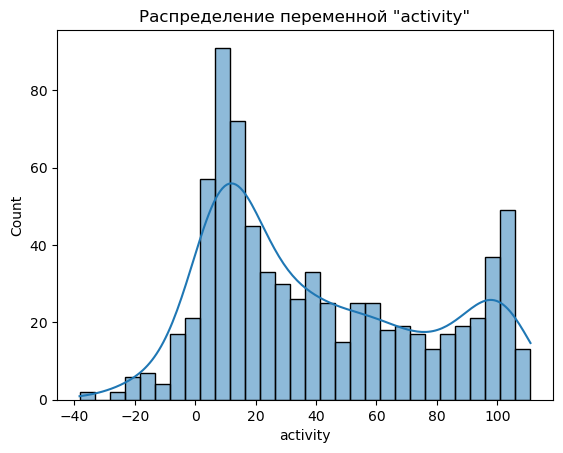

2025-04-16 20:38:12,611 - INFO - Вычисление дескрипторов...



 RMSE: 30.3872
 MAE: 24.8702
 R²: 0.2819


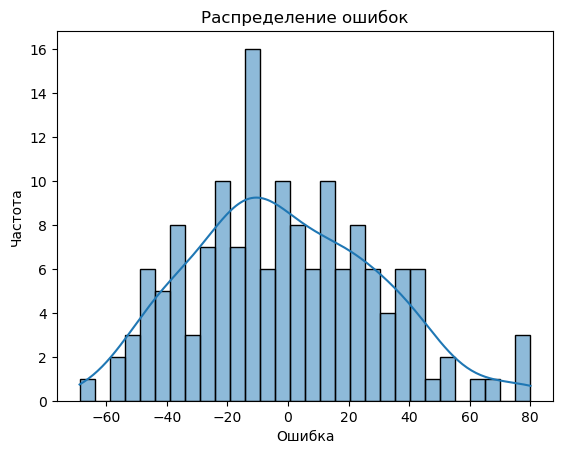

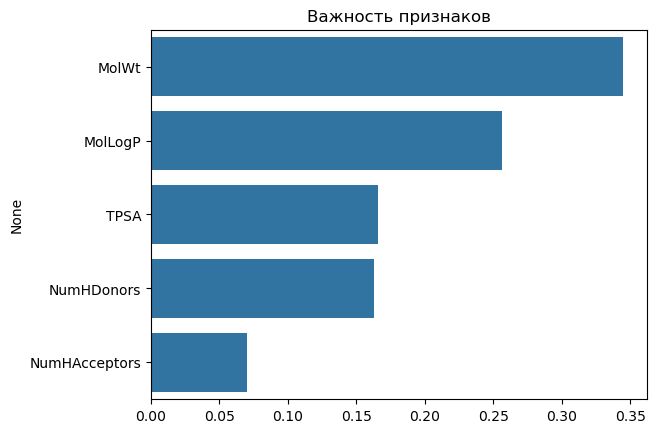

2025-04-16 20:38:32,984 - INFO - Завершено успешно!


In [49]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
from rdkit import Chem
from rdkit.Chem import Descriptors
import logging

# Настройка логирования
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Функция для вычисления дескрипторов
def calculate_descriptors(smiles: str) -> list:
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        logging.warning(f"Не удалось создать молекулу для SMILES: {smiles}")
        return [np.nan] * 5
    return [
        Descriptors.MolWt(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.NumHAcceptors(mol),
        Descriptors.MolLogP(mol),
        Descriptors.TPSA(mol),
    ]

# Пути к данным
data_folder = 'C:\\IDE\\Основы машинного обучения\\итог'
train_data = pd.read_csv(os.path.join(data_folder, 'train.csv'))
test_data = pd.read_csv(os.path.join(data_folder, 'test_only_smiles.csv'))

# Удаление лишнего столбца
train_data.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')
test_data.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')

# Анализ данных
logging.info("Анализ структуры данных:")
print(train_data.info())
print(train_data.describe())

# Визуализация распределения целевой переменной
sns.histplot(train_data['activity'], bins=30, kde=True)
plt.title('Распределение переменной "activity"')
plt.show()

# Вычисление дескрипторов
logging.info("Вычисление дескрипторов...")
train_data['descriptors'] = train_data['SMILES'].apply(calculate_descriptors)
test_data['descriptors'] = test_data['SMILES'].apply(calculate_descriptors)

# Распаковка дескрипторов
descriptors_columns = ['MolWt', 'NumHDonors', 'NumHAcceptors', 'MolLogP', 'TPSA']
train_data[descriptors_columns] = pd.DataFrame(train_data['descriptors'].tolist(), index=train_data.index)
test_data[descriptors_columns] = pd.DataFrame(test_data['descriptors'].tolist(), index=test_data.index)

# Удаление строк с некорректными SMILES
train_data.dropna(subset=descriptors_columns, inplace=True)
test_data.dropna(subset=descriptors_columns, inplace=True)

# Удаление лишнего
train_data.drop(columns=['SMILES', 'descriptors'], inplace=True)
test_data.drop(columns=['descriptors'], inplace=True)

# Обработка пропущенных значений
train_data.fillna(train_data.median(), inplace=True)
test_data_numeric = test_data.drop(columns=['SMILES']).select_dtypes(include=[np.number])
test_data_numeric.fillna(test_data_numeric.median(), inplace=True)
test_data.update(test_data_numeric)

# Разделение на X и y
X = train_data.drop(columns=['activity'])
y = train_data['activity']

# Train/val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Масштабирование
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# GridSearch
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
grid_search = GridSearchCV(GradientBoostingRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
best_model = grid_search.best_estimator_

# Оценка
y_pred = best_model.predict(X_val_scaled)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"\n RMSE: {rmse:.4f}")
print(f" MAE: {mae:.4f}")
print(f" R²: {r2:.4f}")

# Визуализация ошибок
sns.histplot(y_val - y_pred, bins=30, kde=True)
plt.title('Распределение ошибок')
plt.xlabel('Ошибка')
plt.ylabel('Частота')
plt.show()

# Визуализация важности признаков
feature_importances = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False)
sns.barplot(x=feature_importances.values, y=feature_importances.index)
plt.title("Важность признаков")
plt.show()

# Сохранение модели и scaler-а
joblib.dump(best_model, os.path.join(data_folder, 'best_model.pkl'))
joblib.dump(scaler, os.path.join(data_folder, 'scaler.pkl'))

# Предсказание на тесте
X_test = test_data.drop(columns=['SMILES'])
X_test_scaled = scaler.transform(X_test)
test_predictions = best_model.predict(X_test_scaled)
test_data['activity'] = test_predictions

# Сохранение предсказаний
test_data.to_csv(os.path.join(data_folder, 'test_predictions.csv'), index=False)
logging.info("Завершено успешно!")


C:\IDE\Основы машинного обучения\итог\итог.ipynb